<pre style='font-size :25px; text-align: center'><b>ASSIGNMENT 1</b></pre>
<pre style='font-size :20px'><b>INTRODUCTION TO CLUSTERING WITH KMeans AND DBSCAN</b></pre>
<pre style='font-size :15px'>Welcome to your first assignment in unsupervised learning section. 
Today you will be introduced to the methods of clustering such as KMeans and DBSCAN. 
Using the highlighted algorithms you will resolve multiclassification problem and visualize the 
resulting clusters. You will also be shown how to choose the best number of clusters.</pre>

<pre style='font-size : 20px'><b>PART 1</b></pre>
<pre style='font-size : 18px'><b>Working with wine dataset, analysis and processing of data.</b></pre>
<pre style='font-size : 15px;'>Firstly let's import necessary packages. </pre>

In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from pandas.plotting import scatter_matrix
sns.set()

<pre style='font-size : 15px;'>As always, let's read the description of the dataset,
to understand things better.</pre>

In [2]:
''.join(re.split(r'\t|\n',load_wine()['DESCR']))

'.. _wine_dataset:Wine recognition dataset------------------------**Data Set Characteristics:**    :Number of Instances: 178 (50 in each of three classes)    :Number of Attributes: 13 numeric, predictive attributes and the class    :Attribute Information: - Alcohol - Malic acid - Ash- Alcalinity of ash   - Magnesium- Total phenols - Flavanoids - Nonflavanoid phenols - Proanthocyanins- Color intensity - Hue - OD280/OD315 of diluted wines - Proline    - class:            - class_0            - class_1            - class_2    :Summary Statistics:        ============================= ==== ===== ======= =====                                   Min   Max   Mean     SD    ============================= ==== ===== ======= =====    Alcohol:                      11.0  14.8    13.0   0.8    Malic Acid:                   0.74  5.80    2.34  1.12    Ash:                          1.36  3.23    2.36  0.27    Alcalinity of Ash:            10.6  30.0    19.5   3.3    Magnesium:                    70.0 16

<pre style='font-size : 15px;'>Now, we will cast our dictionary containing data to dataframe.</pre>

In [3]:
data = dict((i,load_wine().get(i)) for i in ['feature_names','data','target'])

In [4]:
df = pd.DataFrame(columns=data['feature_names'],data=data['data'])

In [5]:
df['target'] = data['target']

In [6]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


<pre style='font-size : 15px;'>That's mandatory to analyse if there are NaN values in our dataframe.</pre>

In [7]:
len(df)

178

In [8]:
len(df.dropna(how='any'))

178

<pre style='font-size : 15px;'>Length of dataframe before and after dropping NaN is the same,
meaning that there are no NaN values in our data. As we are working with multiclassification,
let's understand if our dataset is balanced.
</pre>

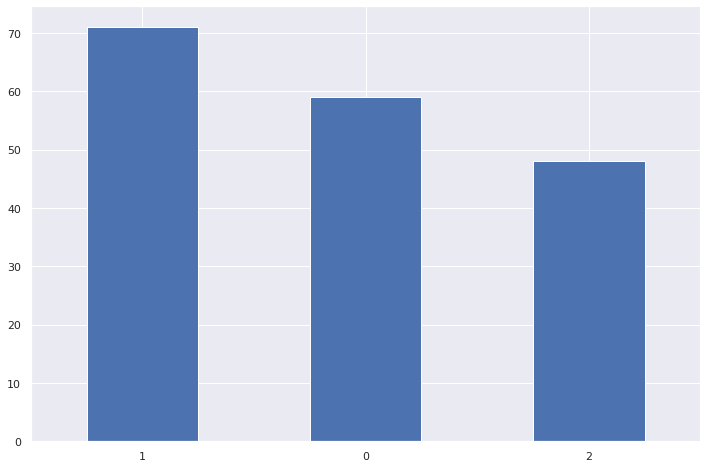

In [9]:
df['target'].value_counts().plot(kind='bar',figsize=(12,8),rot=0);

<pre style='font-size : 15px;'>Seems, that it's not, meaning that we should use f1 score/recall/precision
as the main metric. Next, we'd like to know which features have the biggest impact on target value, 
thus we will use correlation to determine it.
</pre>

In [10]:
def highlight_big_corr(val):
    val = np.abs(val)
    if val>=0.2 and val<0.4:
        color = 'blue'
    elif val>=0.4:
        color='red'
    else:
        color = 'black'
    return 'color: %s' % color
    

In [11]:
df = df[list(df.columns[::-1])]

In [12]:
corr = df.corr()
corr.style.applymap(highlight_big_corr)

,target,proline,od280/od315_of_diluted_wines,hue,color_intensity,proanthocyanins,nonflavanoid_phenols,flavanoids,total_phenols,magnesium,alcalinity_of_ash,ash,malic_acid,alcohol
target,1,-0.633717,-0.78823,-0.617369,0.265668,-0.49913,0.489109,-0.847498,-0.719163,-0.209179,0.517859,-0.0496432,0.437776,-0.328222
proline,-0.633717,1,0.312761,0.236183,0.3161,0.330417,-0.311385,0.494193,0.498115,0.393351,-0.440597,0.223626,-0.192011,0.64372
od280/od315_of_diluted_wines,-0.78823,0.312761,1,0.565468,-0.428815,0.519067,-0.50327,0.787194,0.699949,0.0660039,-0.276769,0.00391123,-0.36871,0.0723432
hue,-0.617369,0.236183,0.565468,1,-0.521813,0.295544,-0.26264,0.543479,0.433681,0.0553982,-0.273955,-0.0746669,-0.561296,-0.0717472
color_intensity,0.265668,0.3161,-0.428815,-0.521813,1,-0.0252499,0.139057,-0.172379,-0.0551364,0.19995,0.018732,0.258887,0.248985,0.546364
proanthocyanins,-0.49913,0.330417,0.519067,0.295544,-0.0252499,1,-0.365845,0.652692,0.612413,0.236441,-0.197327,0.00965194,-0.220746,0.136698
nonflavanoid_phenols,0.489109,-0.311385,-0.50327,-0.26264,0.139057,-0.365845,1,-0.5379,-0.449935,-0.256294,0.361922,0.18623,0.292977,-0.155929
flavanoids,-0.847498,0.494193,0.787194,0.543479,-0.172379,0.652692,-0.5379,1,0.864564,0.195784,-0.35137,0.115077,-0.411007,0.236815
total_phenols,-0.719163,0.498115,0.699949,0.433681,-0.0551364,0.612413,-0.449935,0.864564,1,0.214401,-0.321113,0.12898,-0.335167,0.289101
magnesium,-0.209179,0.393351,0.0660039,0.0553982,0.19995,0.236441,-0.256294,0.195784,0.214401,1,-0.0833331,0.286587,-0.0545751,0.270798


<pre style='font-size : 15px;'>That's obvious that the biggest part of features are highly correlated
with our target. Let's use them for further analysis.
</pre>

In [13]:
highly_correlated = list(corr['target'][np.abs(corr['target'])>0.5].index)

In [14]:
highly_correlated

['target',
 'proline',
 'od280/od315_of_diluted_wines',
 'hue',
 'flavanoids',
 'total_phenols',
 'alcalinity_of_ash']

<pre style='font-size : 15px;'>Today, instead of <b>pandas.plotting.scatter_matrix</b> function
we will use <b>seaborn.pairplot</b> to show the correlation between dataframe columns. 
</pre>

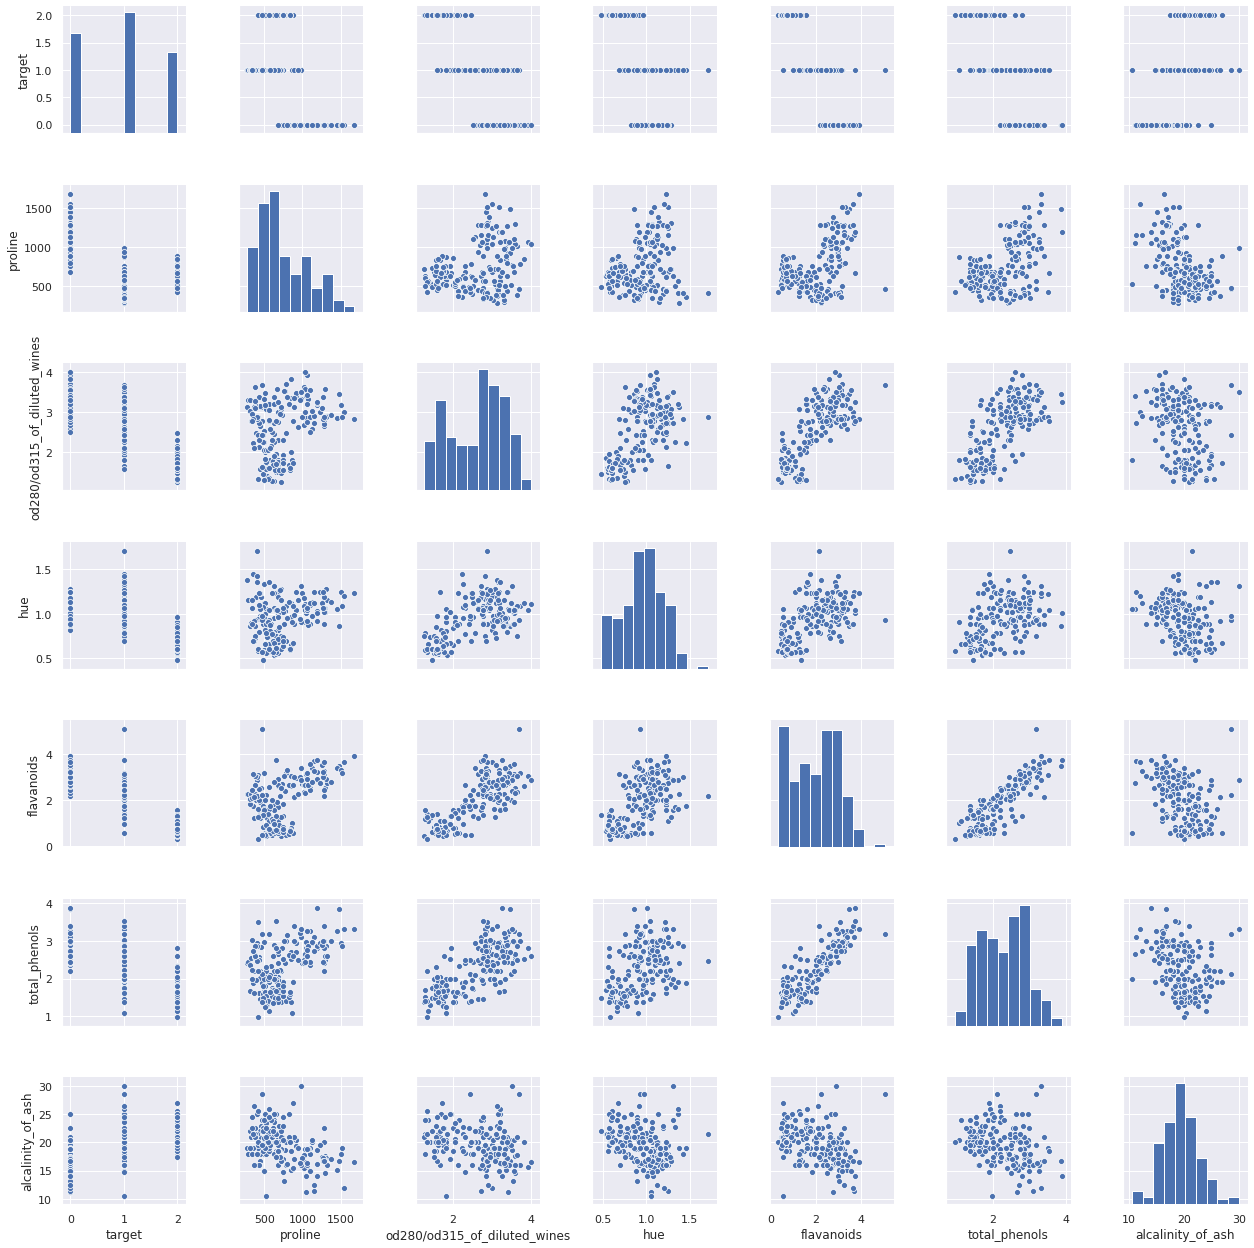

In [15]:
sns.pairplot(df,vars=highly_correlated);

<pre style='font-size : 15px;'>From the figure above it's obvious that our features are highly correlated 
with respect to the target. We can also see a trend in correlation between 
different targets (0,1,2) and features. The insect below shows how the correlation between features
with respect to targets. It's fun, how the target values are clustered by their features.
</pre>

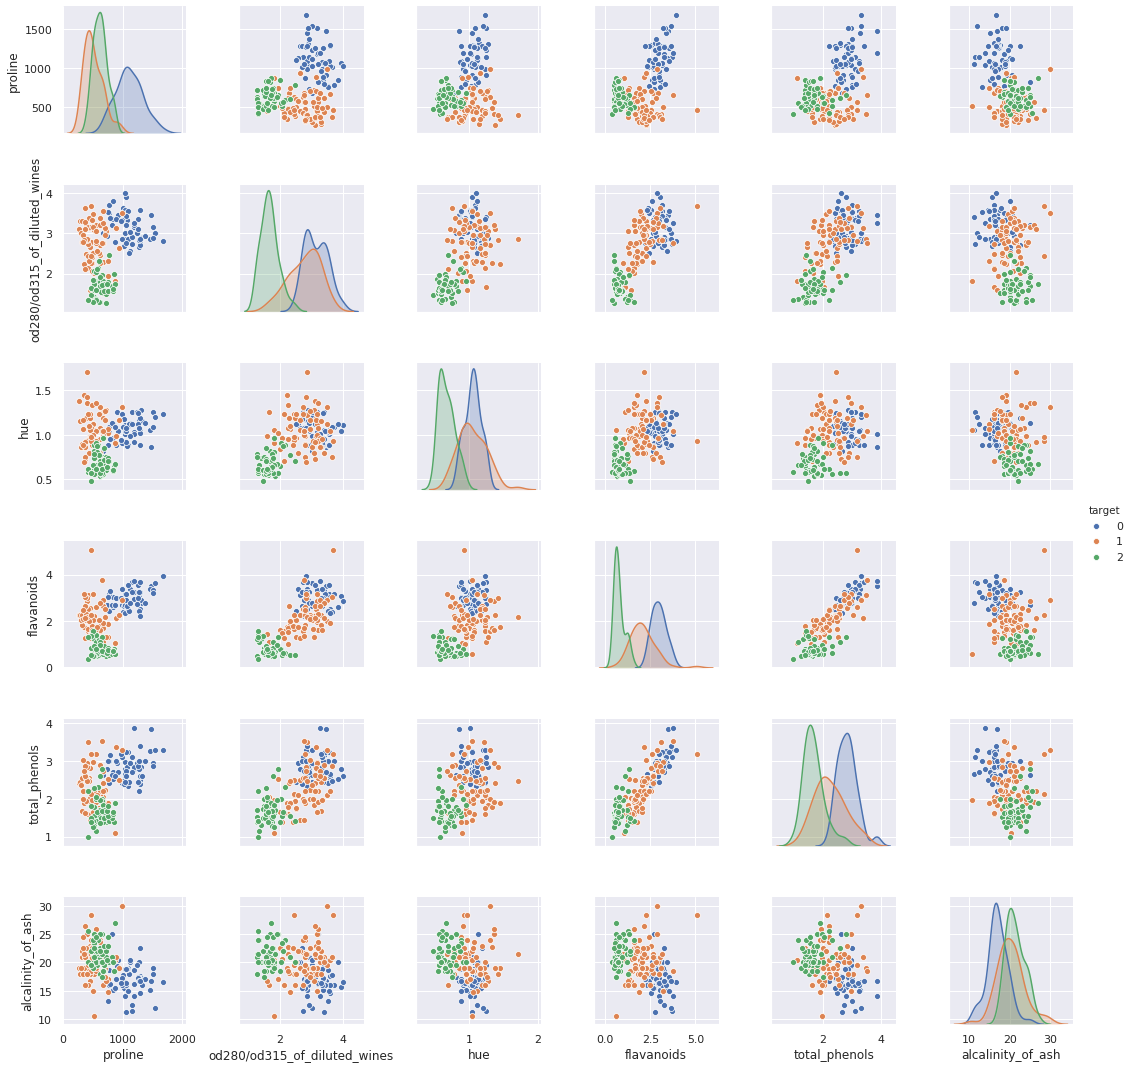

In [16]:
sns.pairplot(df,vars=highly_correlated[1:],hue='target');

<pre style='font-size : 20px'><b>PART 2</b></pre>
<pre style='font-size : 18px'><b>Working with wine dataset, applying KMeans.</b></pre>

In [118]:
from sklearn.cluster import KMeans

In [139]:
columns_to_fit = list(df.columns)

In [140]:
target = columns_to_fit.pop(columns_to_fit.index('target'))

In [141]:
columns_to_fit

['proline',
 'od280/od315_of_diluted_wines',
 'hue',
 'color_intensity',
 'proanthocyanins',
 'nonflavanoid_phenols',
 'flavanoids',
 'total_phenols',
 'magnesium',
 'alcalinity_of_ash',
 'ash',
 'malic_acid',
 'alcohol',
 'kmeans_pred']

In [142]:
target

'target'

<pre style='font-size : 15px;'>When creating KMeans object in sklearn, the one need to specify number 
of clusters. For this particular problem we know that we have 3 distinct classes, thus
number of clusters is 3. Note, that random state is set to 0 for reproducibility.
</pre>

In [143]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(df[columns_to_fit])

<pre style='font-size : 15px;'>The shape of our clusters' centers is number of cluster X number of features.
</pre>

In [145]:
kmeans.cluster_centers_.shape

(3, 14)

<pre style='font-size : 15px;'>The one can see predicted clusters for every data sample using 
<b>labels_</b> function on the kmeans object. 
</pre>

In [149]:
kmeans.labels_

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 2, 2, 0,
       2, 2, 0, 0, 0, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2,
       0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0,
       0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2], dtype=int32)

In [150]:
df[target].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

<pre style='font-size : 15px;'>It's important to understand that cluster names are not aligned
with our classes, as kmeans has no info about groups' names.
</pre>

In [151]:
from sklearn.metrics import f1_score

<pre style='font-size : 15px;'>Computing f1 score on kmeans.labels_ confirms the above sentence.
</pre>

In [152]:
f1_score(df[target].values,kmeans.labels_,average='micro')

0.1853932584269663

<pre style='font-size : 15px;'>The solution is to align kmeans.labels_ with our actual labels.
We assume cluster is related to the class which is dominant in it. Function <b>align_with_class</b>
implements the alignment.
</pre>

In [153]:
def align_with_class(df,kmeans):
    df['kmeans_pred'] = kmeans.labels_
    res = dict()
    for i in df['kmeans_pred'].unique():
        tmp_dict = dict(df[df['kmeans_pred']==i]['target'].value_counts())
        res.update({i:sorted(tmp_dict.items(),key=lambda x: x[1],reverse=True)[0][0]})
    kmeans.labels_ = [res.get(i) for i in kmeans.labels_]
    return kmeans

In [154]:
kmeans = align_with_class(df,kmeans)

<pre style='font-size : 15px;'>As it was expected, we got much higher f1 score.
</pre>

In [156]:
f1_score(df[target].values,kmeans.labels_,average='micro')

0.702247191011236

<pre style='font-size : 15px;'>We can now visualize the clusters found by KMeans.
Function <b>plot_kmeans</b> does it with respect to two features. 
Have fun, specify different features and play around with it.
</pre>

In [159]:
def plot_kmeans(kmeans,df, first='od280/od315_of_diluted_wines', second = 'proline'):
    plt.figure(figsize=(15,12))
    plt.title('Clustered data with two features : {0} and {1}'.format(first,second))
    to_show = df[first], df[second]
    plt.scatter(to_show[0],to_show[1], c=kmeans.labels_, s=50, cmap='viridis')
    centers = kmeans.cluster_centers_
    idx1, idx2 = list(df.columns[1:]).index(first), list(df.columns[1:]).index(second)
    plt.scatter(centers[:, idx1], centers[:, idx2], c='black', s=200, alpha=0.5);

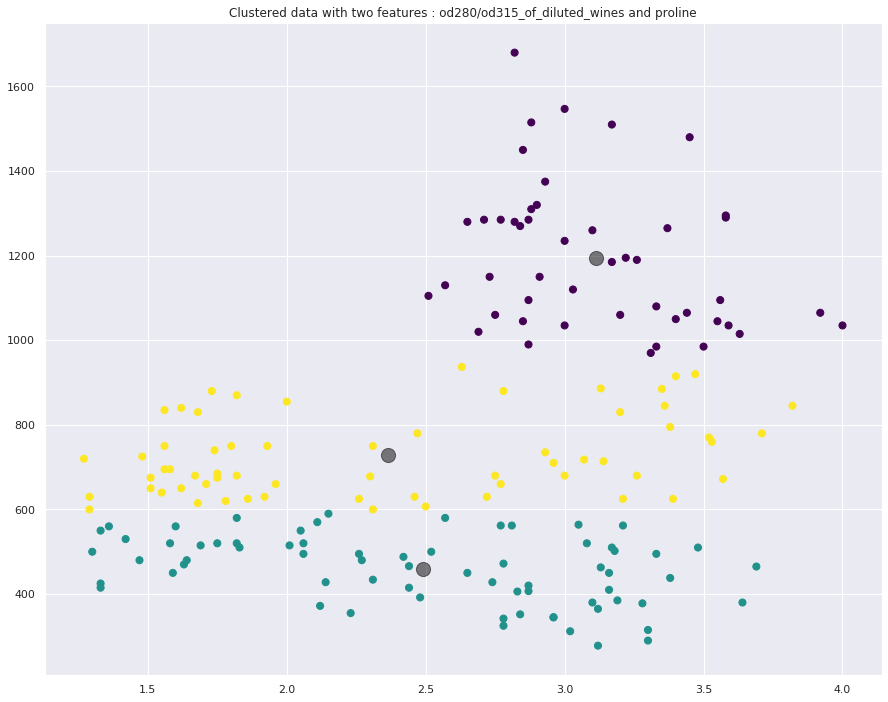

In [160]:
plot_kmeans(kmeans,df)

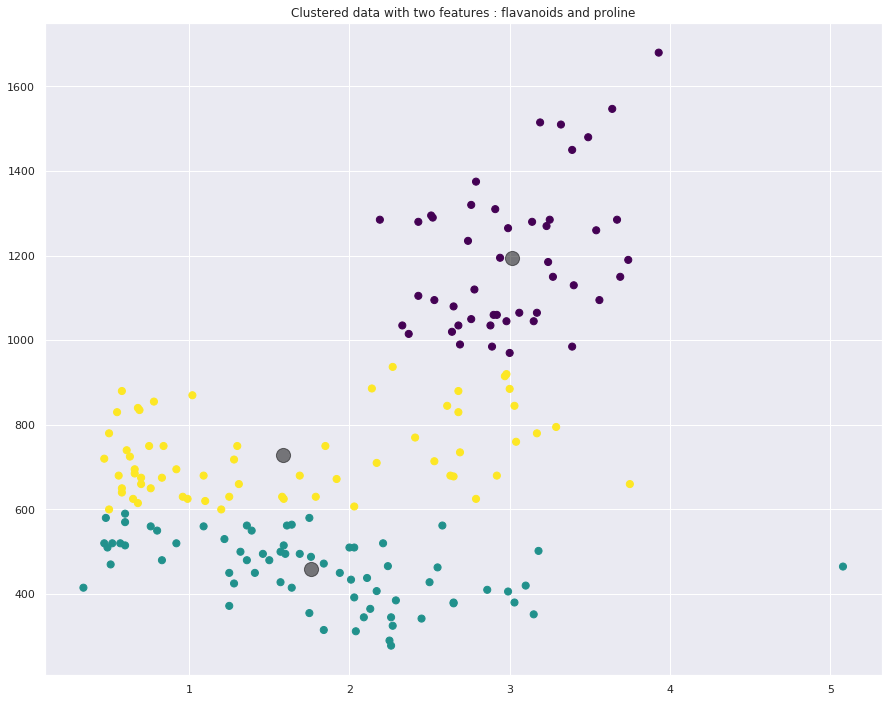

In [161]:
plot_kmeans(kmeans,df,first='flavanoids',second='proline')

<pre style='font-size : 15px;'>Function <b>plot_side_by_side</b> plots real and predicted results 
based on two features.
</pre>

In [163]:
def plot_side_by_side(kmeans,df, first='od280/od315_of_diluted_wines', second = 'proline'):
    fig, ax = plt.subplots(1,2, figsize=(15,12))
    to_show = df[first], df[second]
    fig.suptitle('Clustered data with two features : {0} and {1}'.format(first,second))
    ax[0].title.set_text('Predicted')
    ax[1].title.set_text('Real')
    ax[0].scatter(to_show[0],to_show[1], c=kmeans.labels_, s=50, cmap='viridis')
    ax[1].scatter(to_show[0],to_show[1], c=df['target'].values, s=50, cmap='viridis')

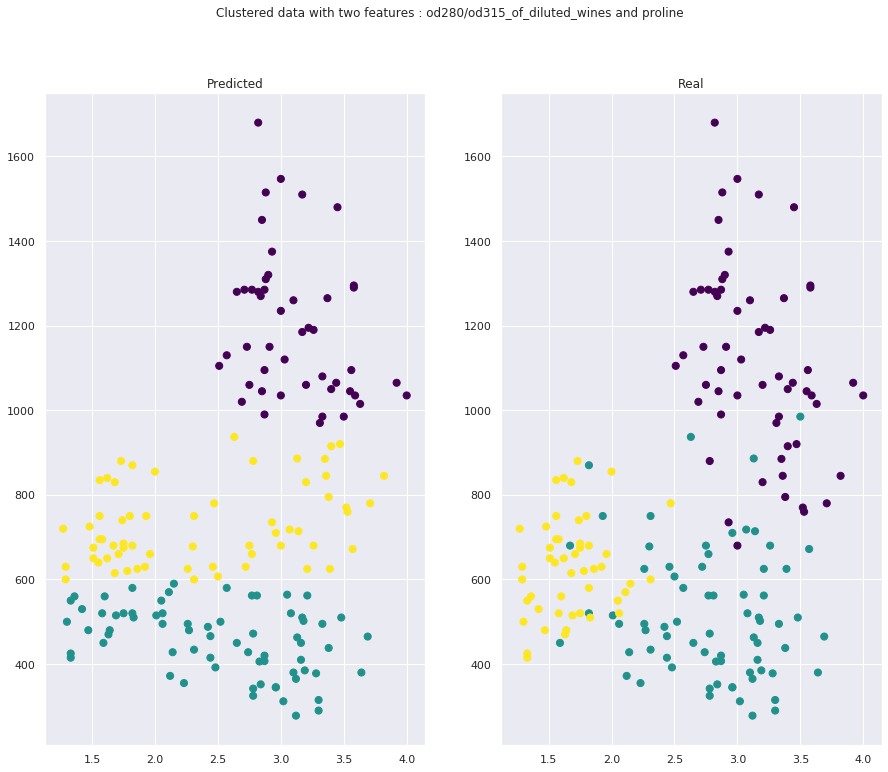

In [164]:
plot_side_by_side(kmeans,df)

<pre style='font-size : 15px;'>To sum up, we can use KMeans to resolve the problem of classification 
and for this kind of problem it's easy to set number of clusters beforehand. 
</pre>

<pre style='font-size : 20px'><b>PART 3</b></pre>
<pre style='font-size : 18px'><b>Methods to specify number of clusters and DBSCAN</b></pre>

<pre style='font-size : 15px;'>Let's import necessary packages and create fake data with 2 features,
10000 samples and 3 classes. 
</pre>

In [276]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

In [281]:
fake_data = make_blobs(n_features=2,n_samples=10000)

In [317]:
fake_data = pd.DataFrame(data=np.hstack((fake_data[0],fake_data[1].reshape(-1,1))),columns=['feature1','feature2','target'])

In [320]:
fake_data.head()

,feature1,feature2,target
0,-7.574157,-3.052424,2.0
1,-7.555990,-4.934735,2.0
2,-9.516014,-4.059361,2.0
3,0.006468,2.378815,0.0
4,-8.581055,-5.093062,2.0


<pre style='font-size : 15px;'>
We will assume that we don't know number of classes before hand, thus we will need to pick 
the best number of clusters ourselves. In order to do it, the one can use Elbow method.
The Elbow method is a very popular technique and the idea is to run k-means clustering 
for a range of clusters k (let’s say from 1 to 10) and for each value, 
we are calculating the sum of squared distances from each point to its assigned 
center(distortions). When the distortions are plotted and the plot looks like an arm, 
then the “elbow” (the point of inflection on the curve) is the best value of k.
The function <b>make_ineria_plot</b> implements Elbow method.</pre>

In [318]:
def make_inertia_plot(data,number=10):
    inertia_list = []
    list_clusters = []
    for i in range(1,number+1):
        kmeans = KMeans(n_clusters=i).fit(data)
        inertia_list.append(kmeans.inertia_)
        list_clusters.append(i)
    plt.figure(figsize=(12,8))
    plt.title('Elbow method')
    plt.scatter(list_clusters,inertia_list,s=50, color='r')
    plt.plot(list_clusters,inertia_list)
    plt.xticks(range(1,number+1))

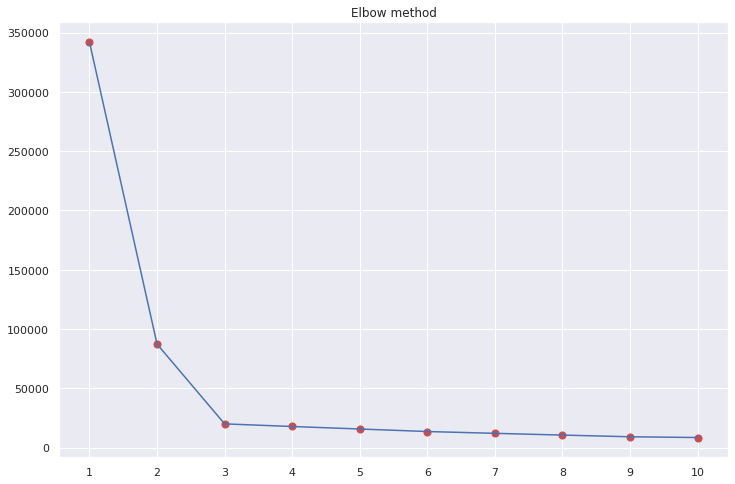

In [319]:
make_inertia_plot(fake_data[['feature1','feature2']])

<pre style='font-size : 15px;'>
From the plot of Elbow method above, it's obvious that the best number of clusters is 3, 
the same as actual number of classes. Let's now plot actual and predicted targets.</pre>

In [321]:
kmeans = KMeans(n_clusters=3).fit(fake_data[['feature1','feature2']])

In [323]:
kmeans = align_with_class(df=fake_data,kmeans=kmeans)

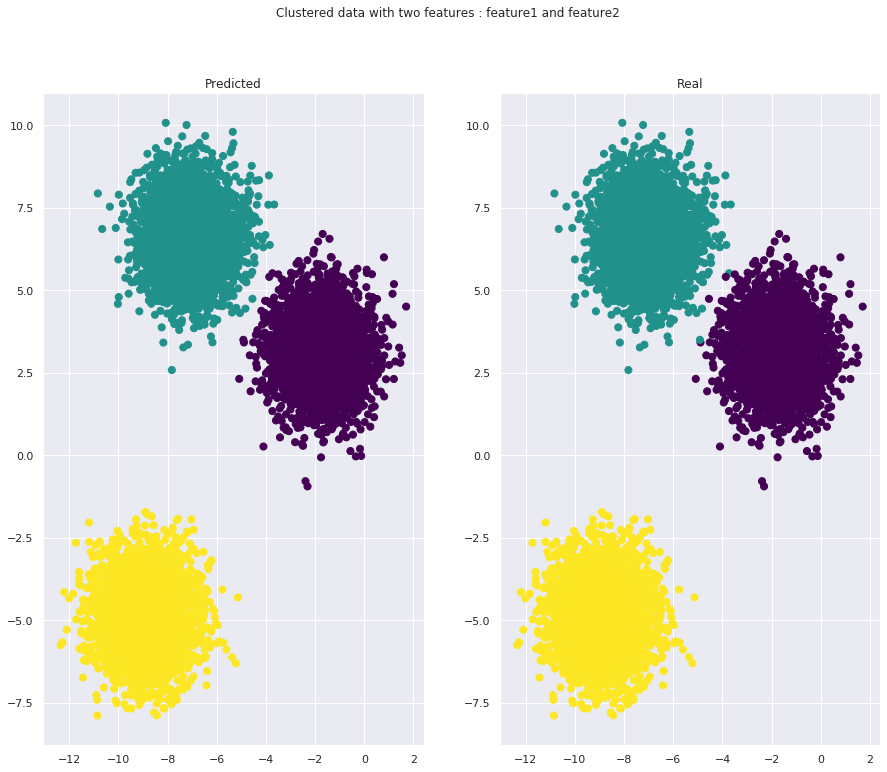

In [324]:
plot_side_by_side(df=fake_data,kmeans=kmeans,first='feature1',second='feature2')

<pre style='font-size : 15px;'>
It seems, that KMeans does a perfect job of clustering the data knowing the exact
number of clusters. Another option is to use DBSCAN.
DBSCAN finds core samples of high density and expands clusters from them, thus 
there is no need to set number of clusters explicitly.</pre>

In [328]:
db = DBSCAN().fit(fake_data[['feature1','feature2']])

<pre style='font-size : 15px;'>
Function <b>plot_dbscan</b> plots DBSCAN predictions. </pre>

In [331]:
def plot_dbscan(db,df, first='od280/od315_of_diluted_wines', second = 'proline'):
    plt.figure(figsize=(15,12))
    plt.title('Clustered data with two features : {0} and {1}'.format(first,second))
    to_show = df[first], df[second]
    plt.scatter(to_show[0],to_show[1], c=kmeans.labels_, s=50, cmap='viridis')

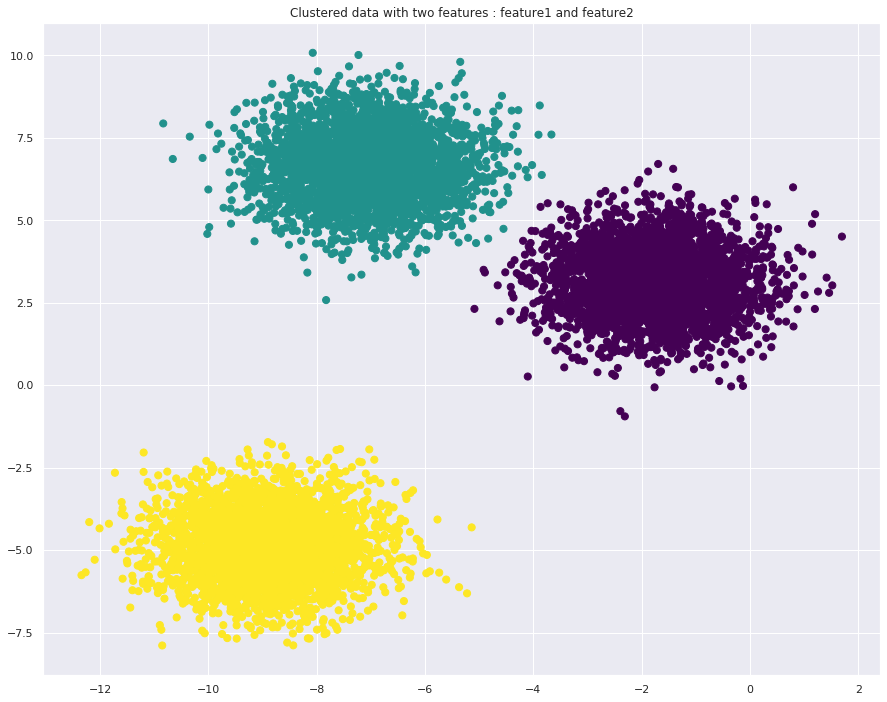

In [332]:
plot_dbscan(db,fake_data,first='feature1',second='feature2')

<pre style='font-size : 15px;'>
As shown above, DBSCAN found the best number of clusters itself without need to choose 
this parameter beforehand.</pre>

<pre style='font-size : 15px;'>
To sum up, today you were introduced to unsupervised learning algorithms 
and were shown how to use them to solve classification problem. You also obtained a knowledge
regarding specifying the best number of clusters for KMeans algorithm and understood an
advantage of using DBSCAN. Next time we will describe some 
applications of unsupervised learning. See you there.
</pre>